# Выбор локации для скважины

Компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Доступны пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Нужно построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap*.

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**

    id — уникальный идентификатор скважины
    f0, f1, f2 — три признака точек 
    product — объём запасов в скважине (тыс. баррелей)

**План проекта**

    1. Подготовка данных
    2. Обучение и проверка модели
    3. Подготовка к расчёту прибыли
    4. Расчёт прибыли
    5. Расчет рисков и прибыли для каждого региона

## 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import scipy.stats as st
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format='retina'
sns.set_palette('pastel')
sns.set_style('white')

In [2]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
def eda(data):
    print(f'Shape: {data.shape}')
    print()
    print('NaNs q-ty:')
    display(data.isna().sum().to_frame().T)
    print('duplicates:', data.duplicated().sum())
    print('duplicates_ex_id:', data[['f0', 'f1', 'f2', 'product']].duplicated().sum())
    print()
    print('Корреляция')
    display(data.corr().round(3))
    sns.pairplot(data)
    plt.show()

Shape: (100000, 5)

NaNs q-ty:


,id,f0,f1,f2,product
0,0,0,0,0,0


duplicates: 0
duplicates_ex_id: 0

Корреляция


,f0,f1,f2,product
f0,1.000,-0.441,-0.003,0.144
f1,-0.441,1.000,0.002,-0.192
f2,-0.003,0.002,1.000,0.484
product,0.144,-0.192,0.484,1.000


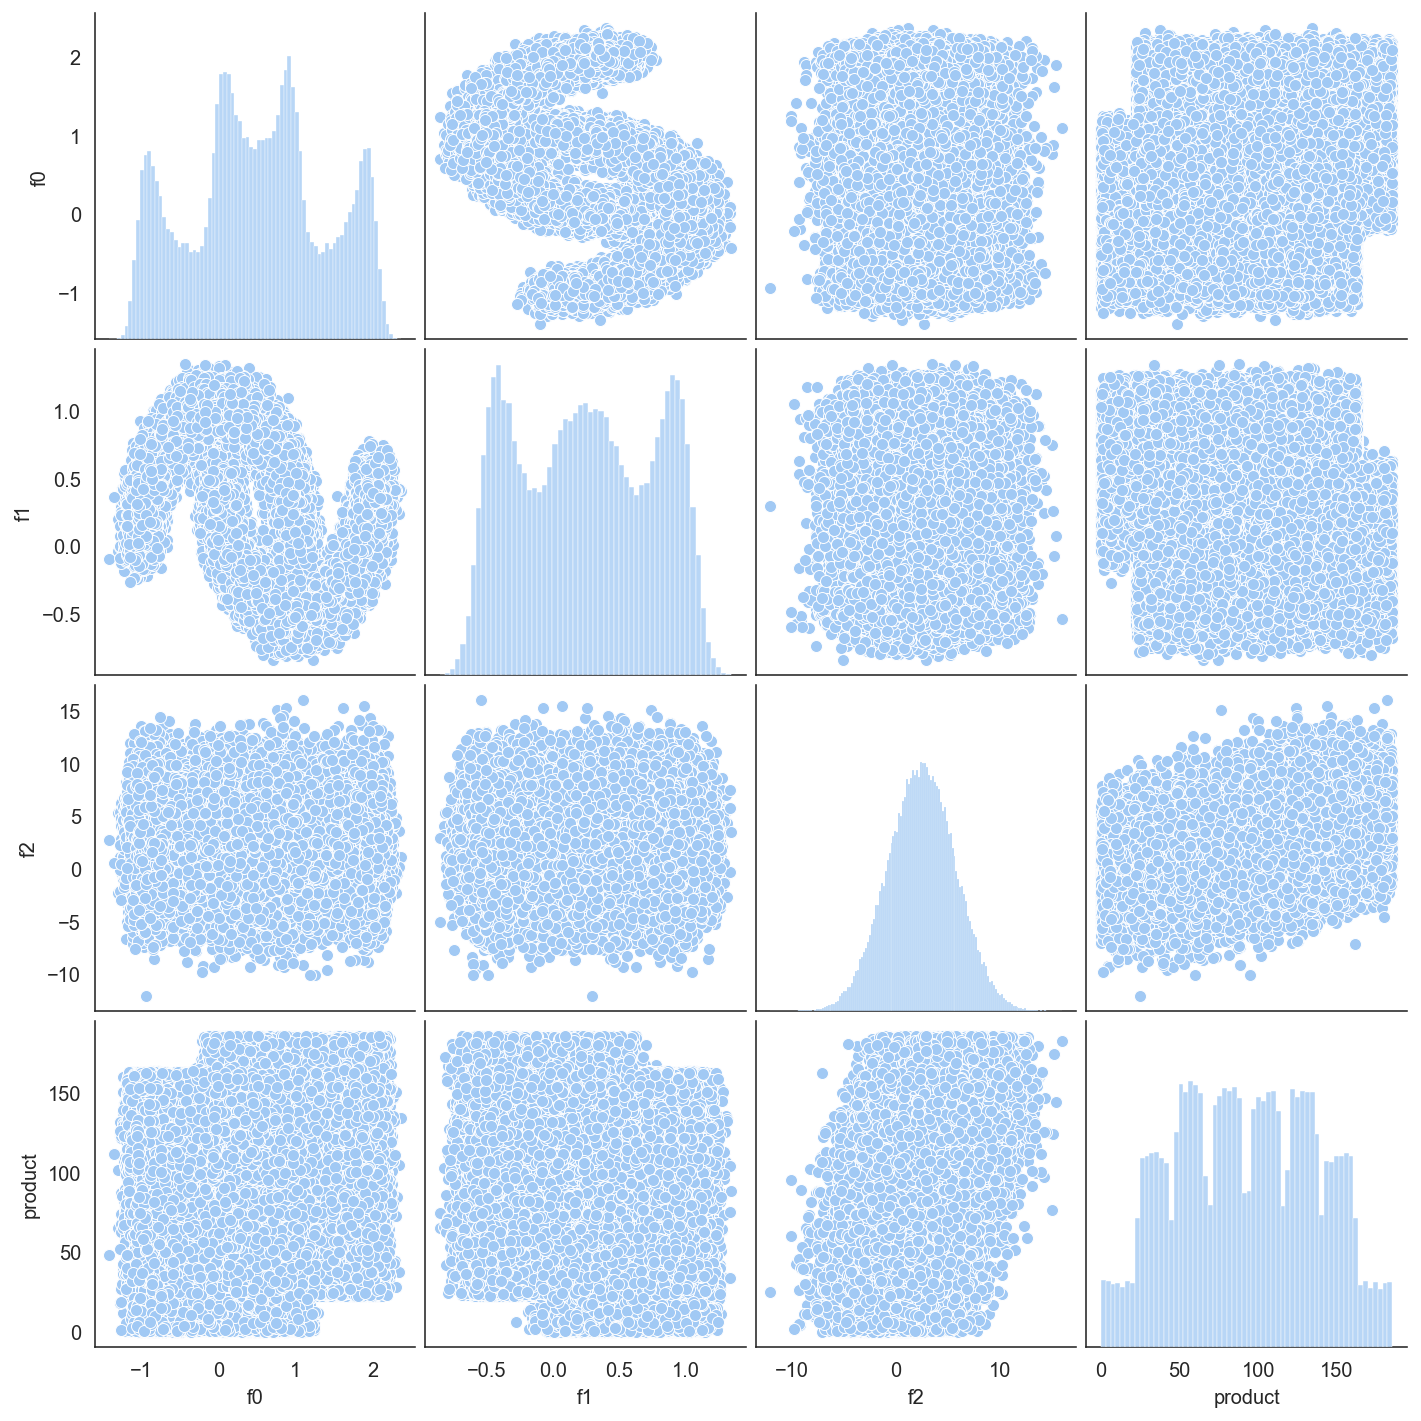

In [4]:
eda(data_0)

Shape: (100000, 5)

NaNs q-ty:


,id,f0,f1,f2,product
0,0,0,0,0,0


duplicates: 0
duplicates_ex_id: 0

Корреляция


,f0,f1,f2,product
f0,1.000,0.182,-0.002,-0.030
f1,0.182,1.000,-0.003,-0.010
f2,-0.002,-0.003,1.000,0.999
product,-0.030,-0.010,0.999,1.000


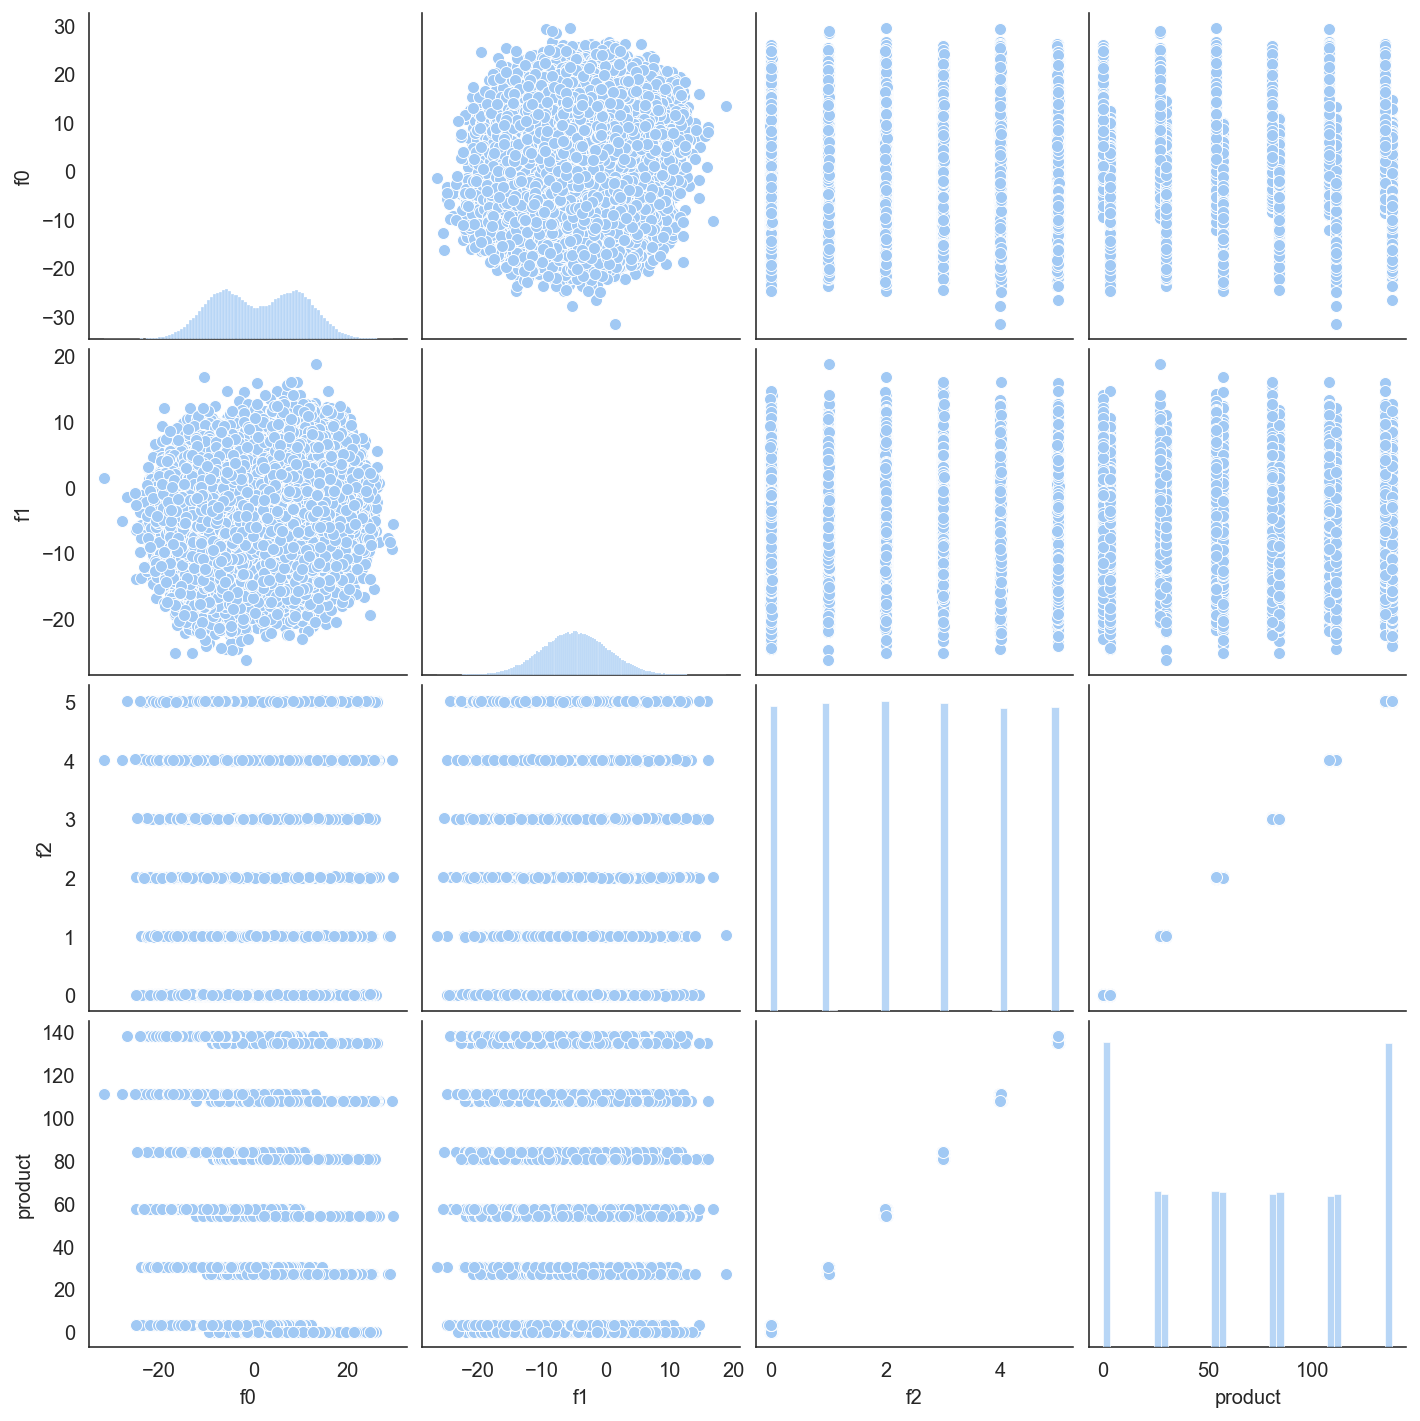

In [5]:
eda(data_1)

Shape: (100000, 5)

NaNs q-ty:


,id,f0,f1,f2,product
0,0,0,0,0,0


duplicates: 0
duplicates_ex_id: 0

Корреляция


,f0,f1,f2,product
f0,1.000,0.001,-0.000,-0.002
f1,0.001,1.000,0.001,-0.001
f2,-0.000,0.001,1.000,0.446
product,-0.002,-0.001,0.446,1.000


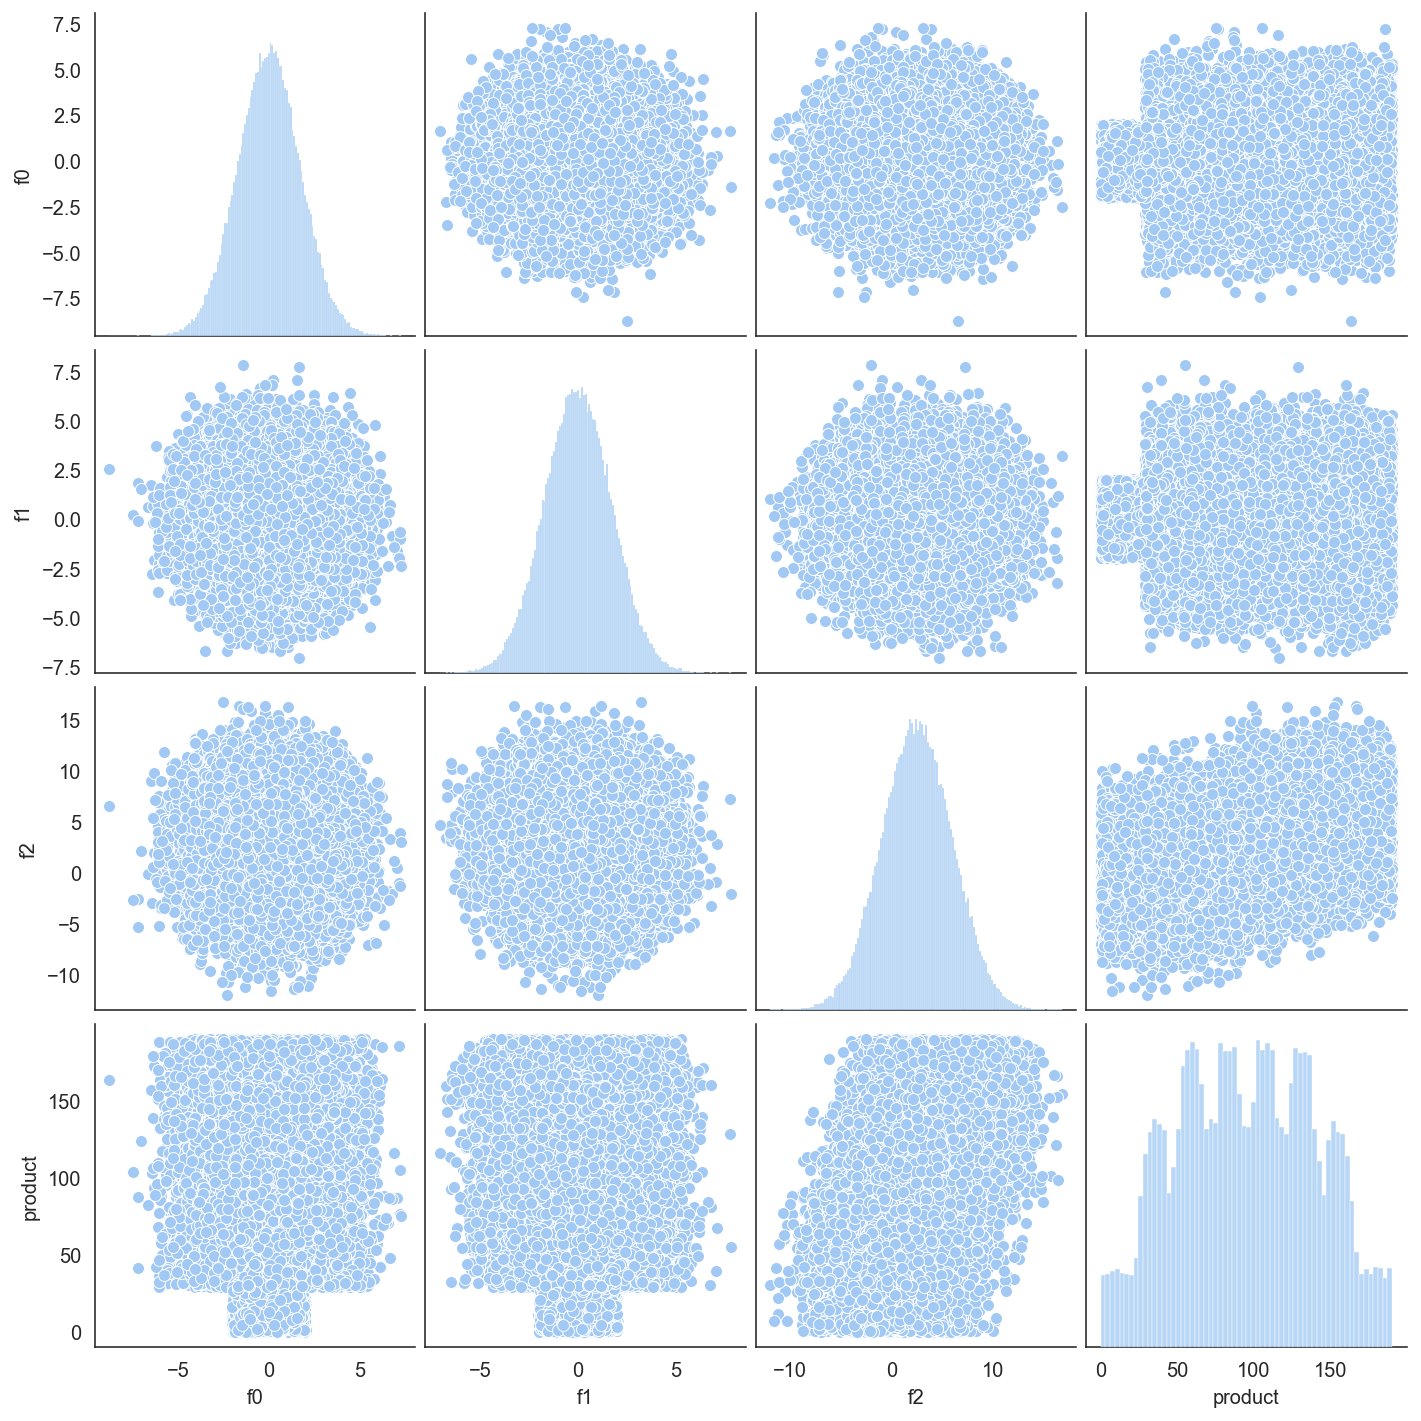

In [6]:
eda(data_2)

In [7]:
display(data_0.head())
display(data_1.head())
display(data_2.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [8]:
data_0.describe().T[['min', 'max']].join(data_1.describe().T[['min', 'max']], lsuffix='_0', rsuffix='_1').    \
                                              join(data_2.describe().T[['min', 'max']]).round(2)

,min_0,max_0,min_1,max_1,min,max
f0,-1.41,2.36,-31.61,29.42,-8.76,7.24
f1,-0.85,1.34,-26.36,18.73,-7.08,7.84
f2,-12.09,16.00,-0.02,5.02,-11.97,16.74
product,0.00,185.36,0.00,137.95,0.00,190.03


Исходные данные - это три массива 10 тыс записей по 5-ти признакам, пропуски и дубликаты отсутствуют, в одном из массивом присутствует корреляция между двумя признаками

## 2. Обучение и проверка модели

- разобъем данные на обучающую и валидационную выборки в соотношении 3:1
- обучим модель и сделаем предсказания на валидационной выборке
- сохраним предсказания и правильные ответы на валидационной выборке
- выведем средний запас предсказанного сырья и RMSE модели

In [9]:
def split_and_train(data):
    
    features = data.drop(['product','id'], axis=1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, 
                                                                                                    random_state=432)
    
    model = LinearRegression(normalize=False)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    predictions = pd.Series(predictions)
    rmse = (mean_squared_error(predictions, target_valid))**(0.5)
    average_product = sum(predictions) / len(predictions)
    
    print("RMSE: {0:.2f}".format(rmse))
    print("Average product: {0:.2f}".format(average_product))
    
    return (predictions, target_valid.reset_index(drop=True), rmse)

In [10]:
predictions_0, target_valid_0, rmse_0 = split_and_train(data_0)
predictions_1, target_valid_1, rmse_1 = split_and_train(data_1)
predictions_2, target_valid_2, rmse_2 = split_and_train(data_2)

RMSE: 37.73
Average product: 92.57
RMSE: 0.89
Average product: 69.13
RMSE: 40.09
Average product: 94.95


На втором массиве модель выдает наименьшую ошибку RMSE

## 3. Подготовка к расчёту прибыли

Бюджет на разработку составляет 10 млрд руб, доход от одной скважины из 200, которые отбираются для разработки - 450 тыс р.
Таким образом средний запас скважины должен быть равен

10 000 000 000 / (450 000 * 200) = 10 000 / 90 = 1 000 / 9 = 111    (тыс баррелей)

In [11]:
round(1000/9)

111

Запас одной скважины, включенной в разработку, должен составлять в среднем 111 тыс баррелей, чтобы покрыть затраты на разработку. Средние запасы регионов (без отбора скважин) не достигают нужной цифры

## 4. Расчёт прибыли

Функция расчета прибыли
 - выбераем скважины (кол-во 200) с максимальными значениями предсказаний
 - суммируем целевое значение объёма сырья, соответствующее этим предсказаниям
 - возвращаем прибыль для полученного объёма сырья

In [12]:
INCOME_PER_THOUS_BARREL = 450000
BUDGET = 10000000000

In [13]:
def profit(predictions, target):
    top_predictions = predictions.sort_values(ascending=False)
    target_200 = target[top_predictions.index][:200]
    revenue = target_200.sum() * INCOME_PER_THOUS_BARREL
    return revenue - BUDGET

## 5. Расчет рисков и прибыли для каждого региона

- применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли
- найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль

In [14]:
state = np.random.RandomState(42)

In [15]:
def get_interv_risk(predictions, target):
    revenue = []
    s = []
    for i in range(1000):
        target_sample = target.sample(n=500, replace=True, random_state=state)
        s.append(len(target_sample))
        predictions_sample = predictions[target_sample.index]
        revenue.append(profit(predictions_sample, target_sample))   
        
    lower = round(pd.Series(revenue).quantile(.025))
    upper = round(pd.Series(revenue).quantile(.975))
    rev_mean = sum(revenue) / len(revenue)
    risk = st.percentileofscore(revenue, 0)

    return ((lower, upper), rev_mean, risk)

In [16]:
i = 0
for prediction, target in zip([predictions_0, predictions_1, predictions_2], [target_valid_0, target_valid_1, target_valid_2]):
    interval, rev_mean, risk = get_interv_risk(prediction, target)
    print(f'Region {i}:')
    print(f'Mean: {round(rev_mean)}')
    print(f'95% confidence interval: {interval}')
    print(f'Risk of loss: {risk}')
    i+=1

Region 0:
Mean: 435322048
95% confidence interval: (-75371522, 973542690)
Risk of loss: 5.1
Region 1:
Mean: 552325098
95% confidence interval: (75984221, 1008599190)
Risk of loss: 0.7
Region 2:
Mean: 369400342
95% confidence interval: (-141035569, 914389162)
Risk of loss: 8.1


# Заключение

В соответсвии с заданными условиями перспективным для разработки является второй регион с вероятностью убытков менее 0,7%, средней прибылью порядка 550 млн руб  